# Worked Examples: Data Augmentation using GANs for Image Generation

## Introduction

Generative Adversarial Networks (GANs) have revolutionized the field of synthetic data generation. Introduced by Ian Goodfellow in 2014, GANs consist of two neural networks—a generator and a discriminator—that compete against each other in a minimax game. The generator aims to create realistic synthetic data, while the discriminator tries to distinguish between real and synthetic samples.

The ability to generate high-quality synthetic data has significant implications for data augmentation, particularly in scenarios where data collection is expensive, time-consuming, or restricted due to privacy concerns. In this notebook, we will explore how GANs can be used for image generation across datasets of varying complexity.

### Objectives

- Compare GAN performance across datasets of varying complexity (MNIST digits vs. Fashion-MNIST clothing)
- Implement and train a Deep Convolutional GAN (DCGAN) architecture
- Evaluate the quality of generated images and training stability
- Explore extensions to improve GAN performance and usefulness

### Why MNIST and Fashion-MNIST?

We've chosen to work with two datasets:

1. **MNIST**: A dataset of handwritten digits (0-9), which consists of 28×28 grayscale images.
2. **Fashion-MNIST**: A dataset of clothing items, also consisting of 28×28 grayscale images.

These datasets are ideal for our comparison because:
- They share the same format (28×28 grayscale) and number of classes (10)
- Fashion-MNIST is generally considered more complex due to higher intra-class variability
- Both are readily available in popular deep learning frameworks (TensorFlow/PyTorch)
- They're small enough to train models quickly without requiring extensive computational resources

Let's begin by setting up our environment and exploring the datasets.

## Setup and Imports


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import time
from IPython import display
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.19.0
GPU Available:  []


## Worked Example 1: MNIST Dataset

### 1.1 Loading and Exploring the MNIST Dataset


In [5]:
# Load the MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Reshape and normalize the images
mnist_train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 28, 28, 1).astype('float32')
mnist_test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
mnist_train_images = (mnist_train_images - 127.5) / 127.5
mnist_test_images = (mnist_test_images - 127.5) / 127.5

# Print dataset information
print("MNIST Training set shape:", mnist_train_images.shape)
print("MNIST Test set shape:", mnist_test_images.shape)
print("Value range:", np.min(mnist_train_images), "to", np.max(mnist_train_images))

# Create a TensorFlow dataset object
BUFFER_SIZE = 60000
BATCH_SIZE = 256

mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

MNIST Training set shape: (60000, 28, 28, 1)
MNIST Test set shape: (10000, 28, 28, 1)
Value range: -1.0 to 1.0


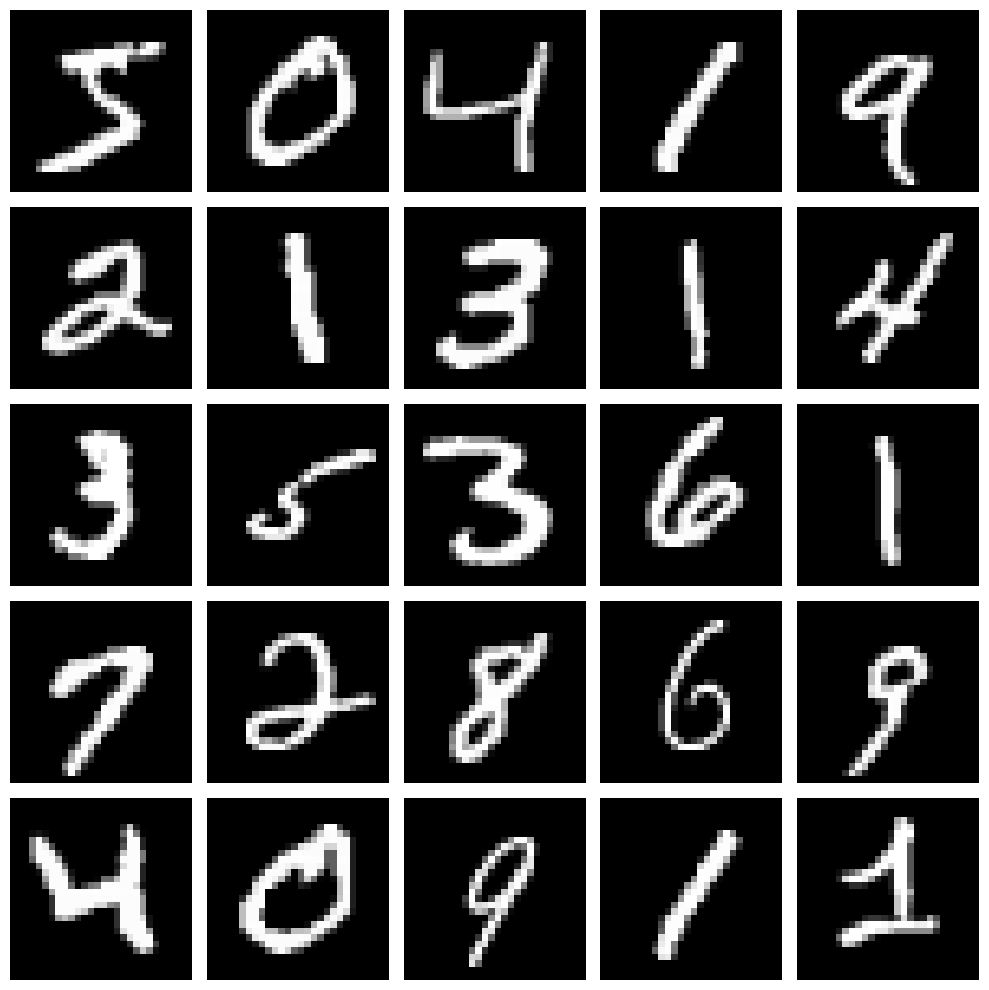

In [7]:
# Visualize some MNIST examples
def show_examples(images, num_examples=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 25 random examples from the MNIST training set
show_examples(mnist_train_images)

### 1.2 Building the DCGAN Architecture

We'll implement a Deep Convolutional GAN (DCGAN) architecture, which has been shown to be effective for image generation tasks. The architecture consists of two main components:

1. **Generator**: Takes random noise as input and generates synthetic images
2. **Discriminator**: Takes an image (real or synthetic) as input and tries to classify it as real or fake

#### 1.2.1 Generator Network


C:\Users\sathu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

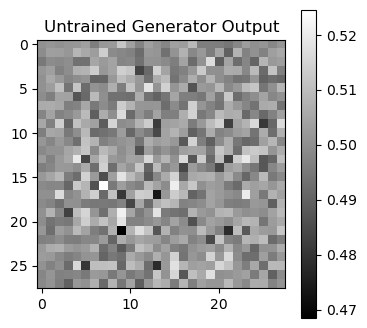

In [10]:
def build_generator(latent_dim=100):
    model = tf.keras.Sequential()
    
    # First dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to start the convolutional layers
    model.add(layers.Reshape((7, 7, 256)))

    # First transposed convolution block
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second transposed convolution block
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Initialize the generator
mnist_generator = build_generator()
mnist_generator.summary()

# Generate a random noise sample
noise = tf.random.normal([1, 100])
generated_image = mnist_generator(noise, training=False)

# Visualize the generated image (before training)
plt.figure(figsize=(4, 4))
plt.imshow(generated_image[0, :, :, 0] * 0.5 + 0.5, cmap='gray')
plt.colorbar()
plt.title('Untrained Generator Output')
plt.show()

#### 1.2.2 Discriminator Network


In [13]:
def build_discriminator():
    model = tf.keras.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second convolutional block
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Flatten and dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

# Initialize the discriminator
mnist_discriminator = build_discriminator()
mnist_discriminator.summary()

# Test the discriminator on a generated image
decision = mnist_discriminator(generated_image)
print("Discriminator output (untrained):", decision.numpy())

C:\Users\sathu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator output (untrained): [[-0.00249947]]


### 1.3 Define Loss Functions and Optimizers


In [16]:
# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 1.4 Training Loop


In [49]:
# Set up the training parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Create the seed for consistent image generation
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Define a function to save generated images
def generate_and_save_images(model, epoch, test_input, save_dir='mnist_images'):
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Generate images from the test input
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    # Save the figure
    plt.savefig(f'{save_dir}/image_at_epoch_{epoch:04d}.png')
    plt.close()

    return predictions

# Define the training step
@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)
        
        # Get discriminator outputs
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Updated train function with optimizers passed as arguments
def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer):
    # Arrays to track loss during training
    gen_losses = []
    disc_losses = []
    
    for epoch in range(epochs):
        start = time.time()
        
        # Track epoch losses
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        steps = 0
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, 
                                             generator_optimizer, discriminator_optimizer)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            steps += 1
        
        # Average losses for the epoch
        epoch_gen_loss /= steps
        epoch_disc_loss /= steps
        gen_losses.append(epoch_gen_loss.numpy())
        disc_losses.append(epoch_disc_loss.numpy())
        
        # Generate and save images
        if (epoch + 1) % 10 == 0 or epoch == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
            
        # Print epoch stats
        print(f'Epoch {epoch+1}, Gen Loss: {epoch_gen_loss:.4f}, Disc Loss: {epoch_disc_loss:.4f}, Time: {time.time()-start:.2f} sec')
    
    # Generate final images
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    return gen_losses, disc_losses

# Train the GAN on MNIST (using MNIST-specific optimizers)
mnist_gen_losses, mnist_disc_losses = train(
    mnist_dataset,
    EPOCHS,
    mnist_generator,
    mnist_discriminator,
    generator_optimizer,
    discriminator_optimizer
)


Epoch 50, Gen Loss: 0.9499, Disc Loss: 1.2368, Time: 48.81 sec


### 1.5 Visualize Training Progress and Results


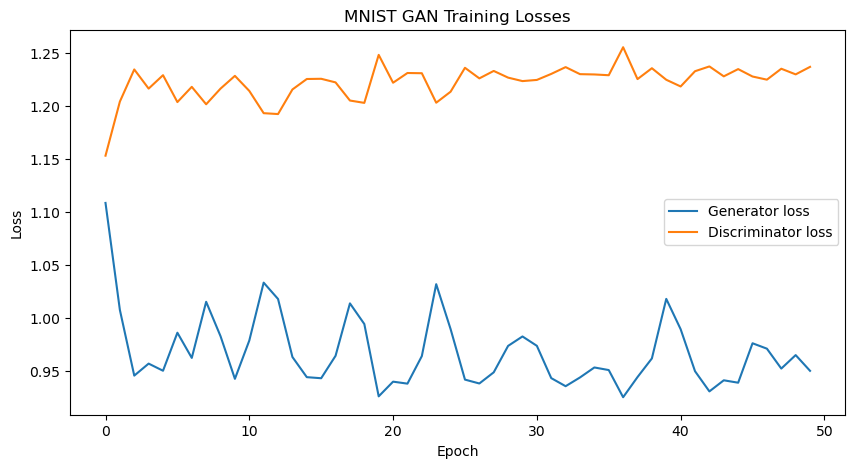

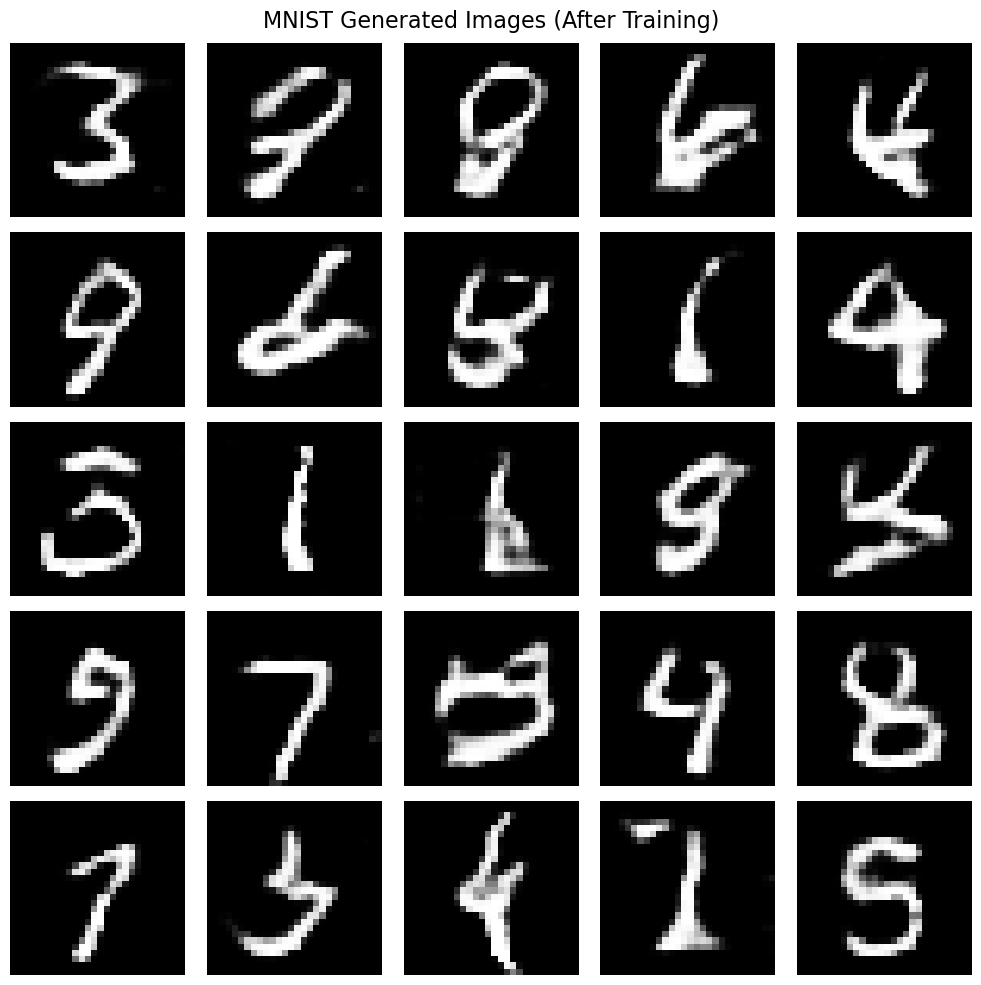

In [51]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(mnist_gen_losses, label='Generator loss')
plt.plot(mnist_disc_losses, label='Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MNIST GAN Training Losses')
plt.savefig('mnist_loss_curves.png')
plt.show()

# Generate a larger batch of images to evaluate quality
n_samples = 100
eval_noise = tf.random.normal([n_samples, noise_dim])
mnist_generated_images = mnist_generator(eval_noise, training=False)

# Visualize a sample of generated MNIST images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(mnist_generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
plt.suptitle('MNIST Generated Images (After Training)', fontsize=16)
plt.tight_layout()
plt.savefig('mnist_final_samples.png')
plt.show()

### 1.6 Discussion of MNIST Results

The MNIST dataset is considered one of the simpler datasets for GANs to learn. Here's why:

1. **Low Variability**: Digits have a relatively simple structure with limited variations in how they're written
2. **Clear Structure**: Each digit has a distinct appearance, making it easier for the generator to capture the distribution
3. **Consistent Background**: All images have a uniform black background with white/gray digits

As observed from our results:
- The generator was able to produce recognizable digits after just a few epochs
- Training was relatively stable as shown by the smooth loss curves
- The final generated images resemble realistic hand-written digits with good variety

## Worked Example 2: Fashion-MNIST Dataset

Now let's apply the same DCGAN architecture to the Fashion-MNIST dataset, which is more complex due to the higher variability in clothing items.

### 2.1 Loading and Exploring the Fashion-MNIST Dataset


In [53]:
# Load the Fashion-MNIST dataset
(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Reshape and normalize the images
fashion_train_images = fashion_train_images.reshape(fashion_train_images.shape[0], 28, 28, 1).astype('float32')
fashion_test_images = fashion_test_images.reshape(fashion_test_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
fashion_train_images = (fashion_train_images - 127.5) / 127.5
fashion_test_images = (fashion_test_images - 127.5) / 127.5

# Print dataset information
print("Fashion-MNIST Training set shape:", fashion_train_images.shape)
print("Fashion-MNIST Test set shape:", fashion_test_images.shape)
print("Value range:", np.min(fashion_train_images), "to", np.max(fashion_train_images))

# Create a TensorFlow dataset object
fashion_dataset = tf.data.Dataset.from_tensor_slices(fashion_train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Fashion-MNIST Training set shape: (60000, 28, 28, 1)
Fashion-MNIST Test set shape: (10000, 28, 28, 1)
Value range: -1.0 to 1.0


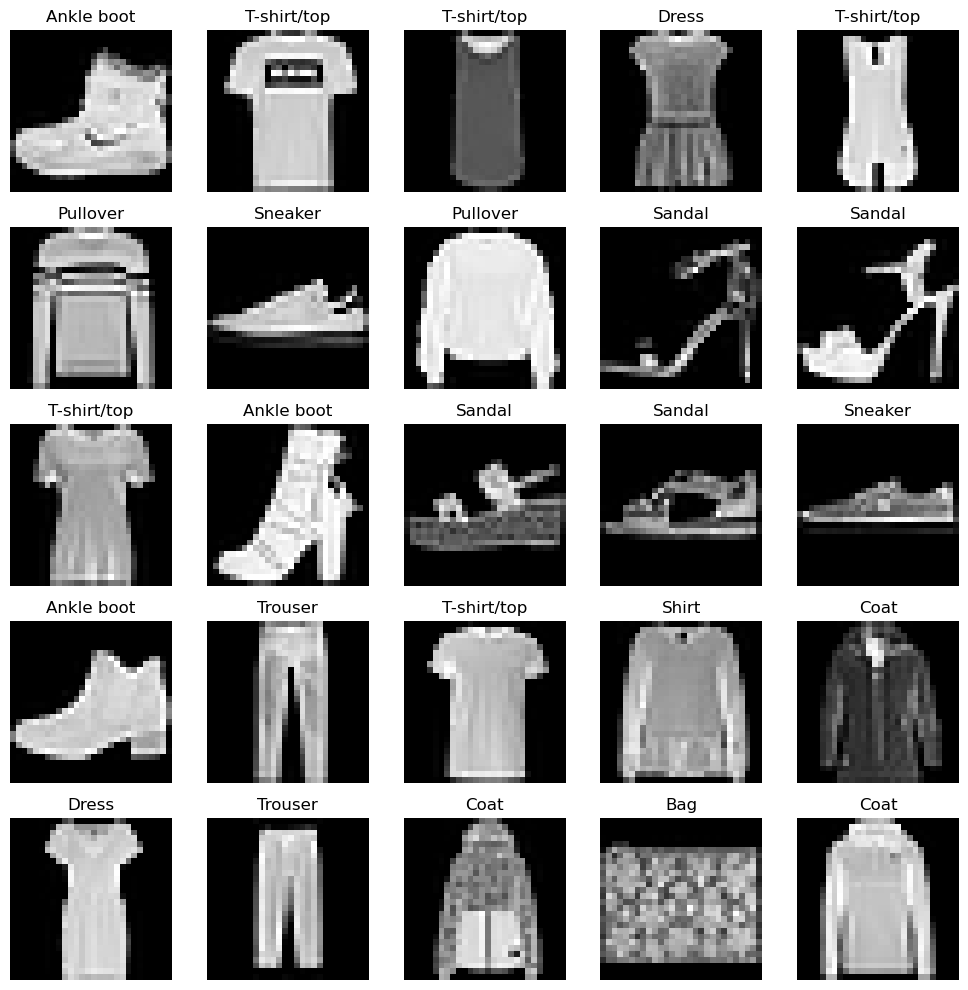

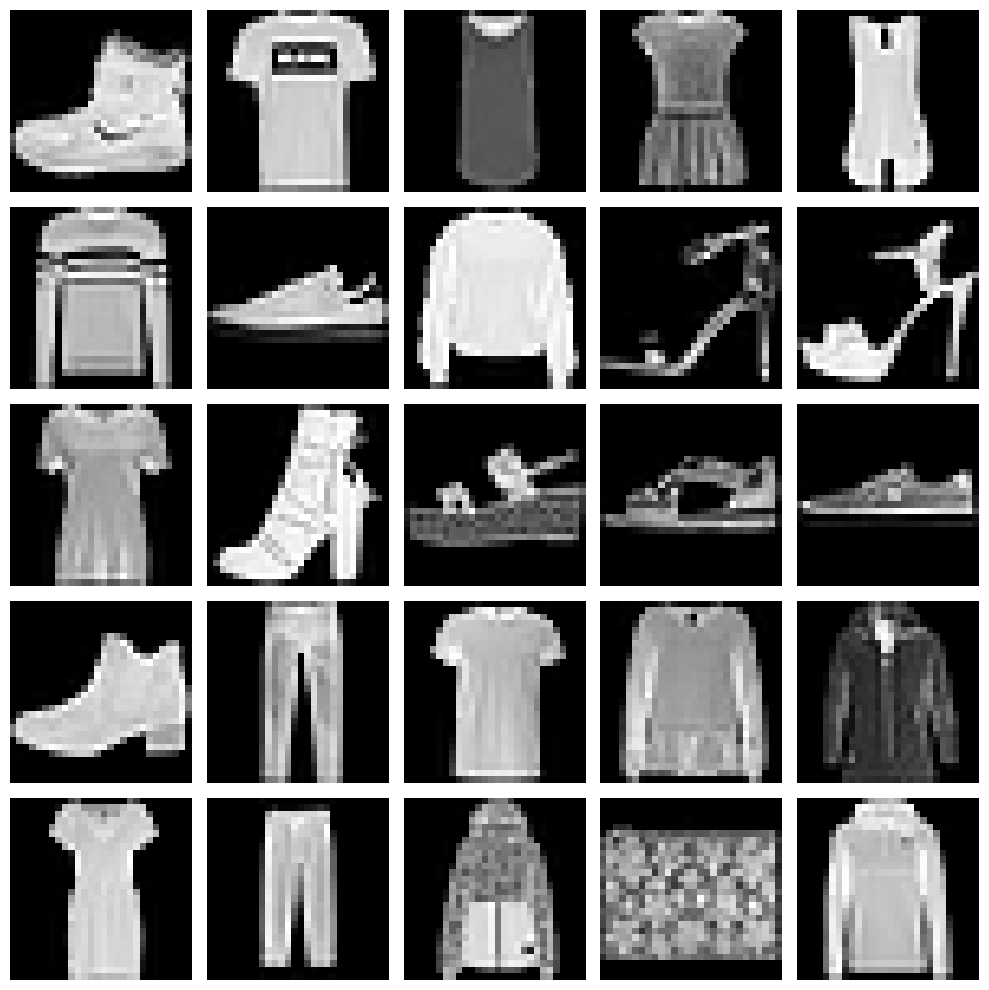

In [55]:
# Class names for the Fashion-MNIST dataset
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize some Fashion-MNIST examples with class labels
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(fashion_train_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.title(fashion_class_names[fashion_train_labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.savefig('fashion_mnist_examples.png')
plt.show()

# Now show examples without labels for a cleaner view
show_examples(fashion_train_images)


### 2.2 Reusing the DCGAN Architecture

We'll use the same DCGAN architecture for Fashion-MNIST that we used for MNIST.


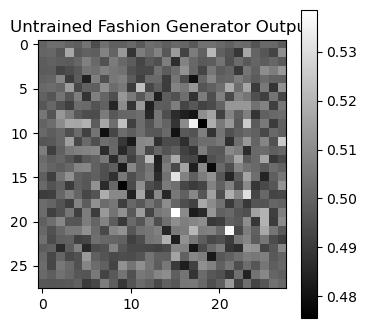

In [58]:
# Initialize new models for Fashion-MNIST
fashion_generator = build_generator()
fashion_discriminator = build_discriminator()

# Test the untrained generator
fashion_noise = tf.random.normal([1, 100])
fashion_generated_image = fashion_generator(fashion_noise, training=False)

plt.figure(figsize=(4, 4))
plt.imshow(fashion_generated_image[0, :, :, 0] * 0.5 + 0.5, cmap='gray')
plt.colorbar()
plt.title('Untrained Fashion Generator Output')
plt.show()

# Define new optimizers specific to Fashion GAN
fashion_generator_optimizer = tf.keras.optimizers.Adam(1e-4)
fashion_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


### 2.3 Training the Fashion-MNIST GAN


In [63]:
# Warm-up train_step to initialize variables
dummy_images = tf.random.normal([BATCH_SIZE, 28, 28, 1])
_ = train_step(
    dummy_images,
    fashion_generator,
    fashion_discriminator,
    fashion_generator_optimizer,
    fashion_discriminator_optimizer
)

# Create a new seed for consistent image generation
fashion_seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Train the Fashion-MNIST GAN
fashion_gen_losses, fashion_disc_losses = train(
    fashion_dataset,
    EPOCHS,
    fashion_generator,
    fashion_discriminator,
    fashion_generator_optimizer,
    fashion_discriminator_optimizer
)


Epoch 50, Gen Loss: 1.5778, Disc Loss: 0.9088, Time: 49.30 sec


### 2.4 Visualize Fashion-MNIST Results


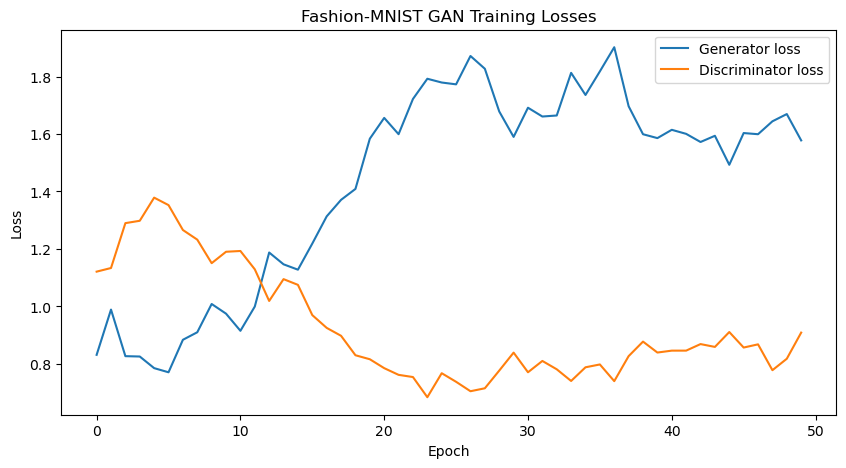

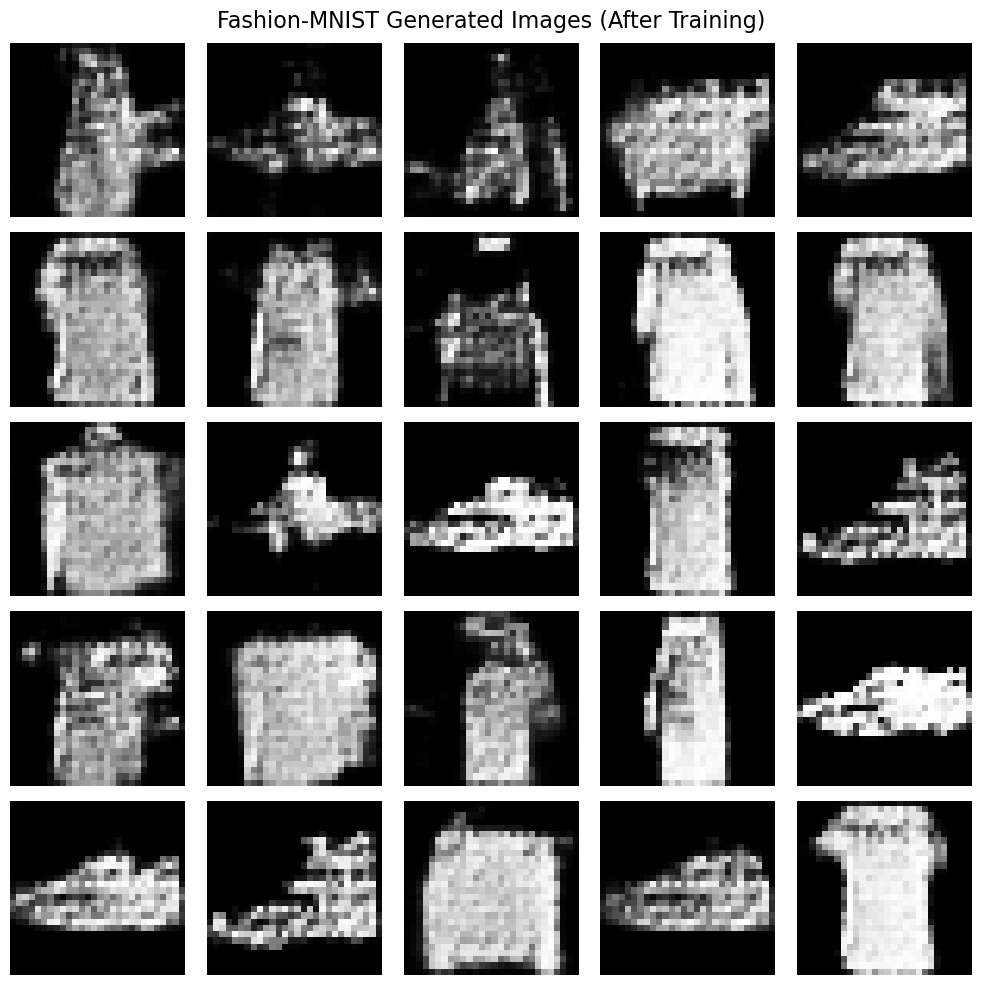

In [65]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(fashion_gen_losses, label='Generator loss')
plt.plot(fashion_disc_losses, label='Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Fashion-MNIST GAN Training Losses')
plt.savefig('fashion_loss_curves.png')
plt.show()

# Generate a larger batch of images
fashion_eval_noise = tf.random.normal([n_samples, noise_dim])
fashion_generated_images = fashion_generator(fashion_eval_noise, training=False)

# Visualize a sample of generated Fashion-MNIST images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(fashion_generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
plt.suptitle('Fashion-MNIST Generated Images (After Training)', fontsize=16)
plt.tight_layout()
plt.savefig('fashion_final_samples.png')
plt.show()

### 2.5 Discussion of Fashion-MNIST Results

The Fashion-MNIST dataset presents a more challenging task for GANs compared to MNIST:

1. **Higher Complexity**: Clothing items have more complex structures with details like collars, sleeves, etc.
2. **Greater Variability**: More variation in how items of the same class can appear
3. **Textural Details**: Clothing contains textural information that's harder to capture

Our results show:
- The training process was likely less stable, with more fluctuations in the loss curves
- The quality of generated images is generally lower compared to MNIST
- Generated clothing items may have blurrier boundaries and less distinct features

## Comparison of Results Between MNIST and Fashion-MNIST


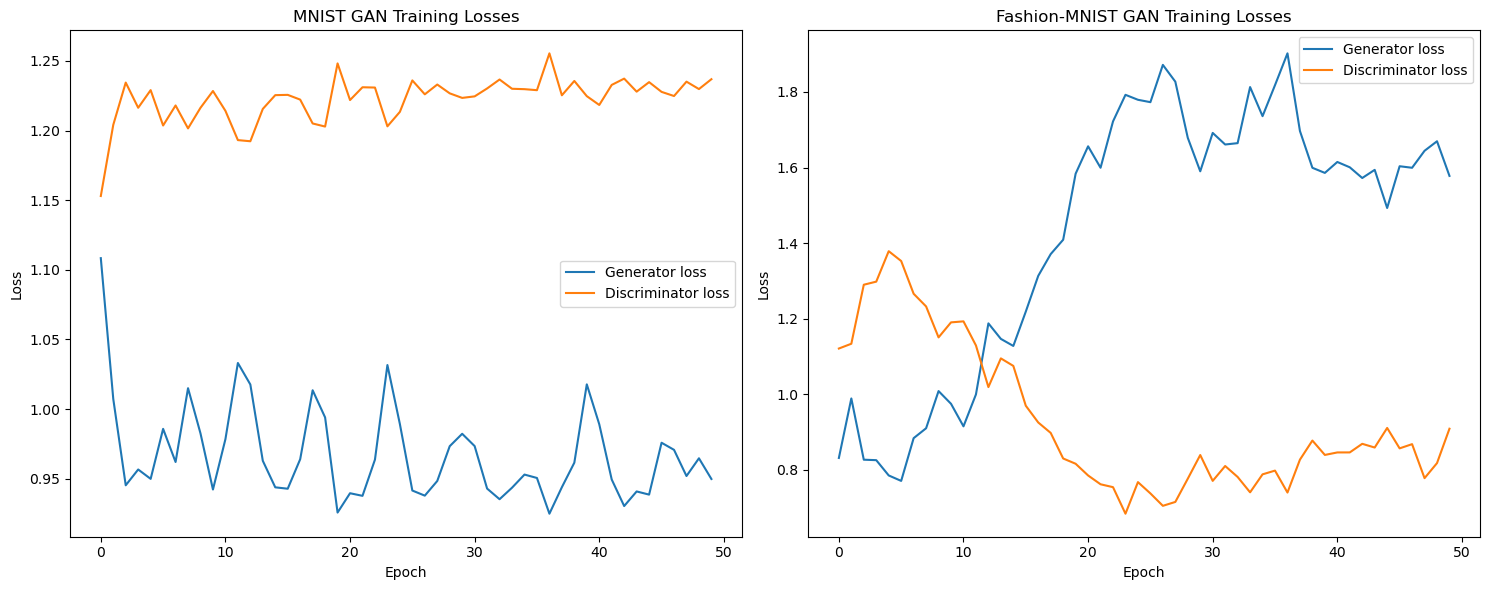

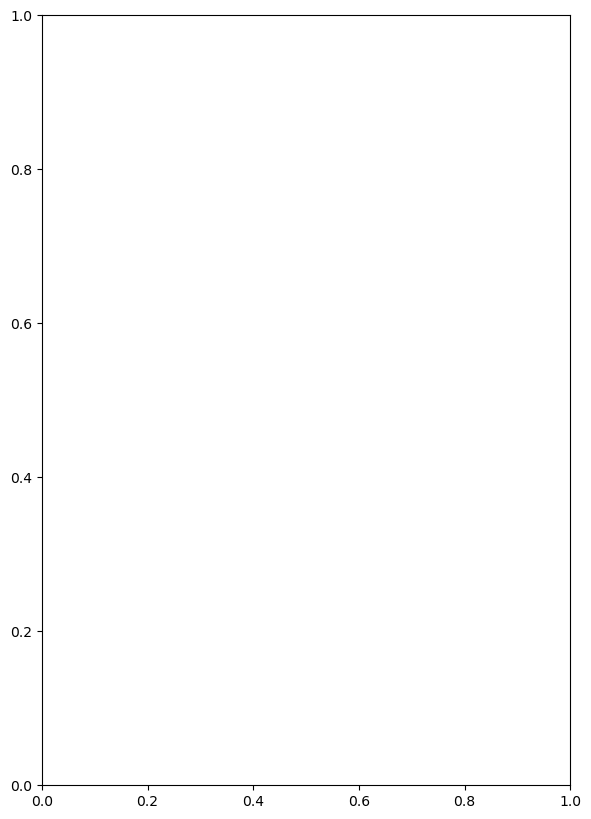

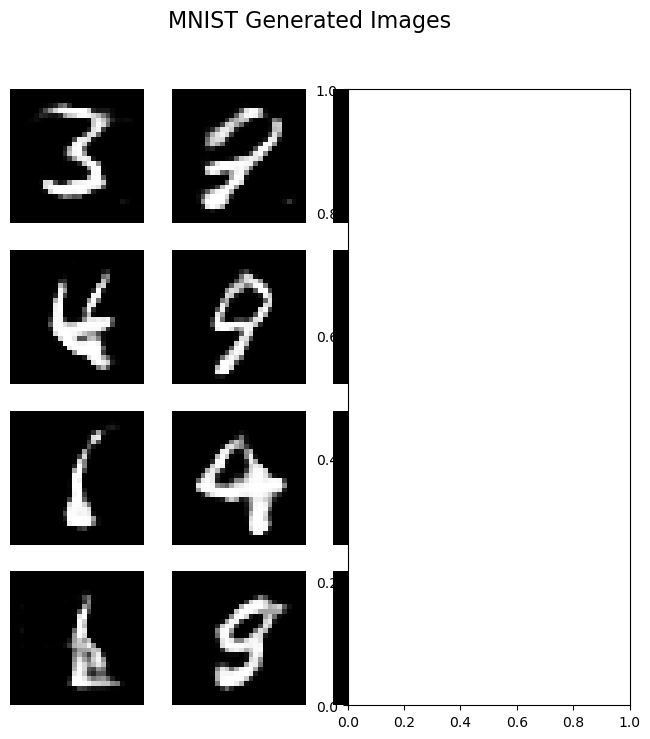

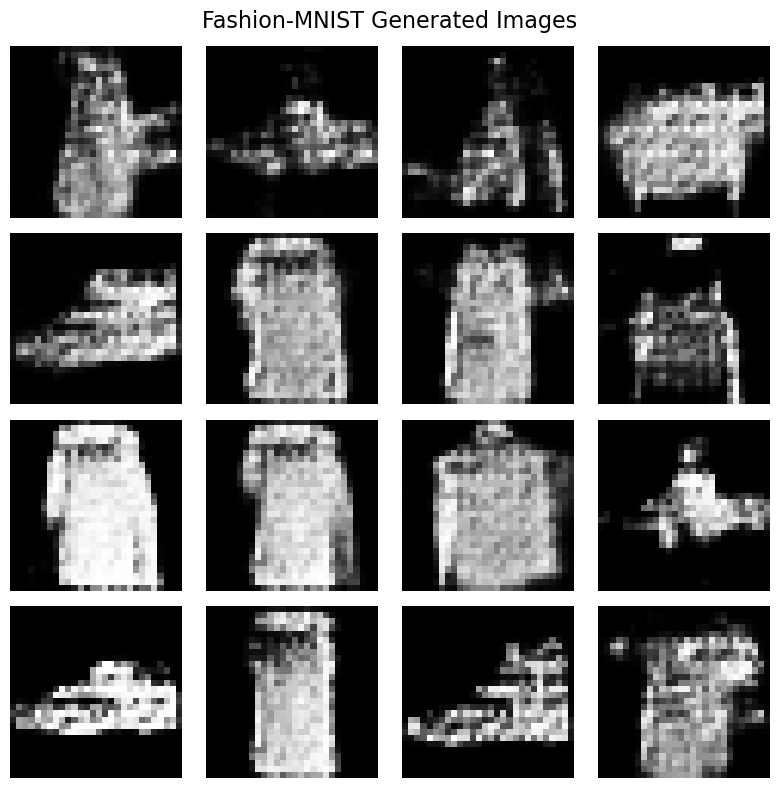

In [67]:
# Compare the loss curves
plt.figure(figsize=(15, 6))

# MNIST Loss Curves
plt.subplot(1, 2, 1)
plt.plot(mnist_gen_losses, label='Generator loss')
plt.plot(mnist_disc_losses, label='Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MNIST GAN Training Losses')

# Fashion-MNIST Loss Curves
plt.subplot(1, 2, 2)
plt.plot(fashion_gen_losses, label='Generator loss')
plt.plot(fashion_disc_losses, label='Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Fashion-MNIST GAN Training Losses')

plt.tight_layout()
plt.savefig('comparison_loss_curves.png')
plt.show()

# Compare the generated images (side by side)
plt.figure(figsize=(15, 10))

# MNIST Generated Images
plt.subplot(1, 2, 1)
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(mnist_generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
plt.suptitle('MNIST Generated Images', fontsize=16)

# Fashion-MNIST Generated Images
plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(fashion_generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
plt.suptitle('Fashion-MNIST Generated Images', fontsize=16)

plt.tight_layout()
plt.savefig('comparison_generated_images.png')
plt.show()

Key observations from the comparison:

1. **Training Stability**:
   - MNIST training shows more stable convergence
   - Fashion-MNIST may exhibit more oscillation in loss values

2. **Image Quality**:
   - MNIST generated images look more realistic and have clearer structures
   - Fashion-MNIST generated images might have more artifacts and less definition

3. **Diversity**:
   - Both datasets show a range of generated examples, but MNIST may have better coverage of different digits
   - The higher complexity of Fashion-MNIST makes it harder for the GAN to capture the full distribution

## Extensions and Exercises

### Extension 1: Evaluation with a Classifier

Let's evaluate the quality of our generated images by training a classifier on real data and testing its performance on the generated samples. The idea is that if our generated images are realistic, the classifier should be able to recognize them correctly.


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9174 - loss: 0.2765 - val_accuracy: 0.9840 - val_loss: 0.0483
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9875 - loss: 0.0430 - val_accuracy: 0.9808 - val_loss: 0.0585
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9913 - loss: 0.0282 - val_accuracy: 0.9864 - val_loss: 0.0467
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9936 - loss: 0.0219 - val_accuracy: 0.9898 - val_loss: 0.0320
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9949 - loss: 0.0159 - val_accuracy: 0.9889 - val_loss: 0.0452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


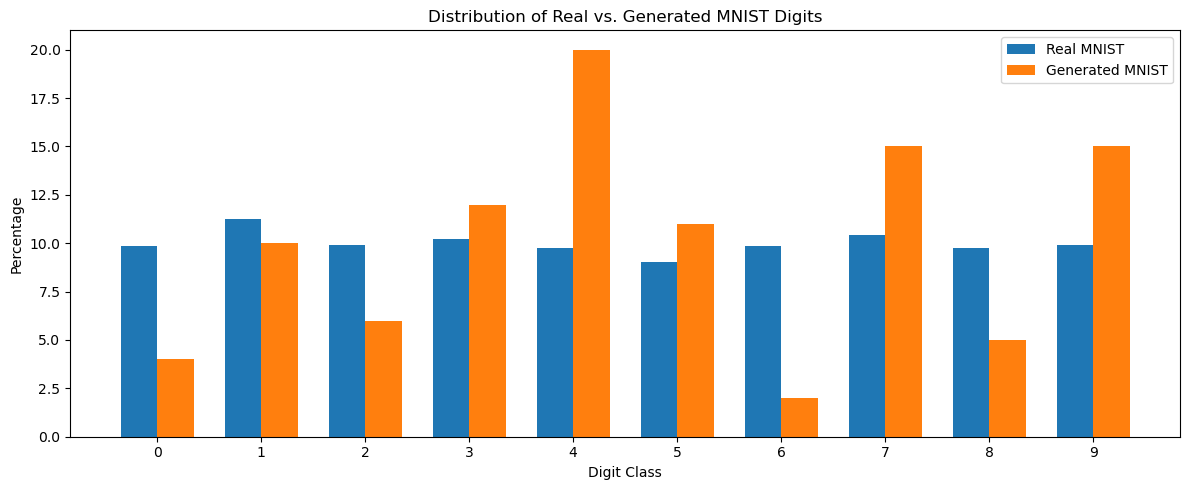

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7912 - loss: 0.5821 - val_accuracy: 0.8846 - val_loss: 0.3336
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8913 - loss: 0.2986 - val_accuracy: 0.8964 - val_loss: 0.2912
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9095 - loss: 0.2483 - val_accuracy: 0.9019 - val_loss: 0.2828
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9231 - loss: 0.2112 - val_accuracy: 0.9017 - val_loss: 0.2857
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9341 - loss: 0.1791 - val_accuracy: 0.9071 - val_loss: 0.2840
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


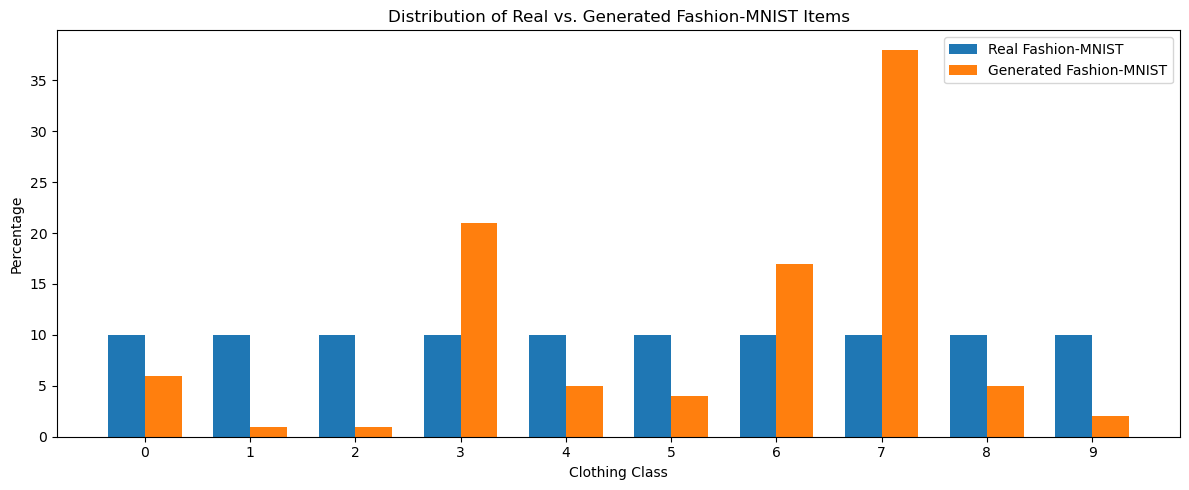

In [76]:
# Build a simple CNN classifier
def build_classifier(num_classes=10):
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    return model


# Train on MNIST
mnist_classifier = build_classifier()
mnist_classifier.fit(mnist_train_images, mnist_train_labels, epochs=5,
                     validation_data=(mnist_test_images, mnist_test_labels))

# Generate class labels for the generated images
def classify_generated_images(generated_images, real_images, real_labels, classifier):
    # Run model on a real batch to initialize the graph
    _ = classifier(real_images[:1])  # Trigger model build with actual data

    # Extract features from the second last layer
    generated_features = classifier.layers[-2].output
    feature_model = tf.keras.Model(inputs=classifier.input, outputs=generated_features)

    # Get features
    gen_features = feature_model.predict(generated_images)
    real_features = feature_model.predict(real_images[:1000])  # Subset for speed

    # Nearest neighbor lookup
    predicted_labels = []
    for gen_feat in gen_features:
        distances = np.sqrt(np.sum((real_features - gen_feat)**2, axis=1))
        closest_idx = np.argmin(distances)
        predicted_labels.append(real_labels[closest_idx])

    return np.array(predicted_labels)

# Classify MNIST generated images
mnist_generated_labels = classify_generated_images(
    mnist_generated_images,
    mnist_train_images,
    mnist_train_labels,
    mnist_classifier
)

# Count and normalize class distributions
mnist_gen_distribution = np.bincount(mnist_generated_labels, minlength=10)
mnist_real_distribution = np.bincount(mnist_train_labels, minlength=10)

mnist_gen_distribution = mnist_gen_distribution / np.sum(mnist_gen_distribution) * 100
mnist_real_distribution = mnist_real_distribution / np.sum(mnist_real_distribution) * 100

# Plot MNIST class distributions
plt.figure(figsize=(12, 5))
bar_width = 0.35
index = np.arange(10)

plt.bar(index, mnist_real_distribution, bar_width, label='Real MNIST')
plt.bar(index + bar_width, mnist_gen_distribution, bar_width, label='Generated MNIST')

plt.xlabel('Digit Class')
plt.ylabel('Percentage')
plt.title('Distribution of Real vs. Generated MNIST Digits')
plt.xticks(index + bar_width/2, range(10))
plt.legend()
plt.tight_layout()
plt.savefig('mnist_class_distribution.png')
plt.show()

# --- Repeat for Fashion-MNIST ---

fashion_classifier = build_classifier()
fashion_classifier.fit(fashion_train_images, fashion_train_labels, epochs=5,
                       validation_data=(fashion_test_images, fashion_test_labels))

fashion_generated_labels = classify_generated_images(
    fashion_generated_images,
    fashion_train_images,
    fashion_train_labels,
    fashion_classifier
)

fashion_gen_distribution = np.bincount(fashion_generated_labels, minlength=10)
fashion_real_distribution = np.bincount(fashion_train_labels, minlength=10)

fashion_gen_distribution = fashion_gen_distribution / np.sum(fashion_gen_distribution) * 100
fashion_real_distribution = fashion_real_distribution / np.sum(fashion_real_distribution) * 100

plt.figure(figsize=(12, 5))
plt.bar(index, fashion_real_distribution, bar_width, label='Real Fashion-MNIST')
plt.bar(index + bar_width, fashion_gen_distribution, bar_width, label='Generated Fashion-MNIST')

plt.xlabel('Clothing Class')
plt.ylabel('Percentage')
plt.title('Distribution of Real vs. Generated Fashion-MNIST Items')
plt.xticks(index + bar_width/2, range(10))
plt.legend()
plt.tight_layout()
plt.savefig('fashion_class_distribution.png')
plt.show()


### Extension 2: Data Augmentation for a Small Classifier

Let's evaluate whether using GAN-generated images to augment a small training set can improve classifier performance.


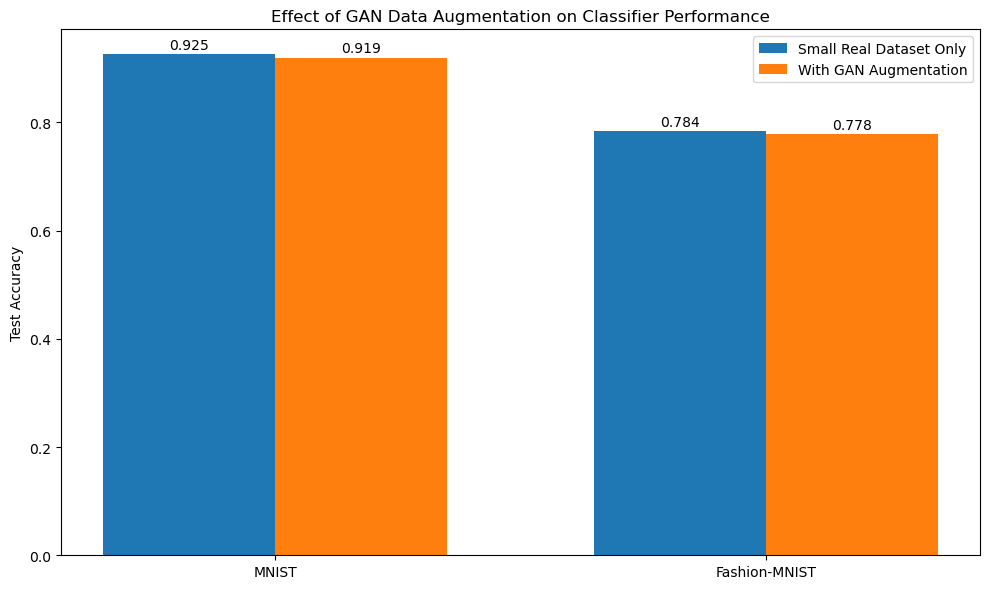

In [80]:
def train_with_augmentation(real_images, real_labels, generated_images, generated_labels, test_images, test_labels, num_real_per_class=100):
    # Convert generated_images to NumPy array for advanced indexing
    generated_images = np.array(generated_images)
    
    # Create a small training set
    small_train_images = []
    small_train_labels = []

    for class_idx in range(10):
        class_indices = np.where(real_labels == class_idx)[0]
        selected_indices = class_indices[:num_real_per_class]
        small_train_images.append(real_images[selected_indices])
        small_train_labels.append(real_labels[selected_indices])

    small_train_images = np.vstack(small_train_images)
    small_train_labels = np.concatenate(small_train_labels)

    # Train a classifier on only the small real dataset
    small_classifier = build_classifier()
    small_classifier.fit(small_train_images, small_train_labels, epochs=5, validation_data=(test_images, test_labels), verbose=0)
    _, small_accuracy = small_classifier.evaluate(test_images, test_labels, verbose=0)

    # Create an augmented dataset with both real and generated images
    augmented_gen_images = []
    augmented_gen_labels = []

    for class_idx in range(10):
        class_indices = np.where(generated_labels == class_idx)[0]
        if len(class_indices) >= num_real_per_class:
            selected_indices = class_indices[:num_real_per_class]
        else:
            selected_indices = np.concatenate(
                [class_indices] * (num_real_per_class // len(class_indices) + 1)
            )[:num_real_per_class]

        augmented_gen_images.append(generated_images[selected_indices])
        augmented_gen_labels.append(np.ones(len(selected_indices), dtype=np.int32) * class_idx)

    augmented_gen_images = np.vstack(augmented_gen_images)
    augmented_gen_labels = np.concatenate(augmented_gen_labels)

    augmented_images = np.vstack([small_train_images, augmented_gen_images])
    augmented_labels = np.concatenate([small_train_labels, augmented_gen_labels])

    indices = np.arange(len(augmented_images))
    np.random.shuffle(indices)
    augmented_images = augmented_images[indices]
    augmented_labels = augmented_labels[indices]

    # Train a classifier on the augmented dataset
    augmented_classifier = build_classifier()
    augmented_classifier.fit(augmented_images, augmented_labels, epochs=5, validation_data=(test_images, test_labels), verbose=0)
    _, augmented_accuracy = augmented_classifier.evaluate(test_images, test_labels, verbose=0)

    return small_accuracy, augmented_accuracy


# Test augmentation on MNIST
mnist_small_acc, mnist_aug_acc = train_with_augmentation(
    mnist_train_images, mnist_train_labels,
    mnist_generated_images, mnist_generated_labels,
    mnist_test_images, mnist_test_labels
)

# Test augmentation on Fashion-MNIST
fashion_small_acc, fashion_aug_acc = train_with_augmentation(
    fashion_train_images, fashion_train_labels,
    fashion_generated_images, fashion_generated_labels,
    fashion_test_images, fashion_test_labels
)

# Plot the results
plt.figure(figsize=(10, 6))
datasets = ['MNIST', 'Fashion-MNIST']
small_accs = [mnist_small_acc, fashion_small_acc]
aug_accs = [mnist_aug_acc, fashion_aug_acc]

x = np.arange(len(datasets))
bar_width = 0.35

plt.bar(x - bar_width/2, small_accs, bar_width, label='Small Real Dataset Only')
plt.bar(x + bar_width/2, aug_accs, bar_width, label='With GAN Augmentation')

plt.ylabel('Test Accuracy')
plt.title('Effect of GAN Data Augmentation on Classifier Performance')
plt.xticks(x, datasets)
plt.legend()

# Add accuracy values on top of bars
for i, (small_acc, aug_acc) in enumerate(zip(small_accs, aug_accs)):
    plt.text(i - bar_width/2, small_acc + 0.01, f'{small_acc:.3f}', ha='center')
    plt.text(i + bar_width/2, aug_acc + 0.01, f'{aug_acc:.3f}', ha='center')

plt.tight_layout()
plt.savefig('augmentation_performance.png')
plt.show()


### Extension 3: Effect of Latent Dimension Size

Let's explore how changing the latent dimension size affects the quality of generated images.


Training MNIST GAN with latent dimension 10


C:\Users\sathu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sathu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 5/20, Gen Loss: 0.8583, Disc Loss: 1.2420
Epoch 10/20, Gen Loss: 0.8600, Disc Loss: 1.3019
Epoch 15/20, Gen Loss: 0.9936, Disc Loss: 1.1636
Epoch 20/20, Gen Loss: 1.0550, Disc Loss: 1.1429
Training MNIST GAN with latent dimension 50
Epoch 5/20, Gen Loss: 0.8680, Disc Loss: 1.2762
Epoch 10/20, Gen Loss: 0.9956, Disc Loss: 1.1421
Epoch 15/20, Gen Loss: 1.0396, Disc Loss: 1.1569
Epoch 20/20, Gen Loss: 1.1004, Disc Loss: 1.1106
Training MNIST GAN with latent dimension 100
Epoch 5/20, Gen Loss: 0.8114, Disc Loss: 1.2977
Epoch 10/20, Gen Loss: 0.8861, Disc Loss: 1.2437
Epoch 15/20, Gen Loss: 0.9900, Disc Loss: 1.2121
Epoch 20/20, Gen Loss: 1.1582, Disc Loss: 1.0549
Training MNIST GAN with latent dimension 200
Epoch 5/20, Gen Loss: 0.9391, Disc Loss: 1.2430
Epoch 10/20, Gen Loss: 0.9498, Disc Loss: 1.1806
Epoch 15/20, Gen Loss: 1.0907, Disc Loss: 1.1222
Epoch 20/20, Gen Loss: 1.2195, Disc Loss: 1.0227


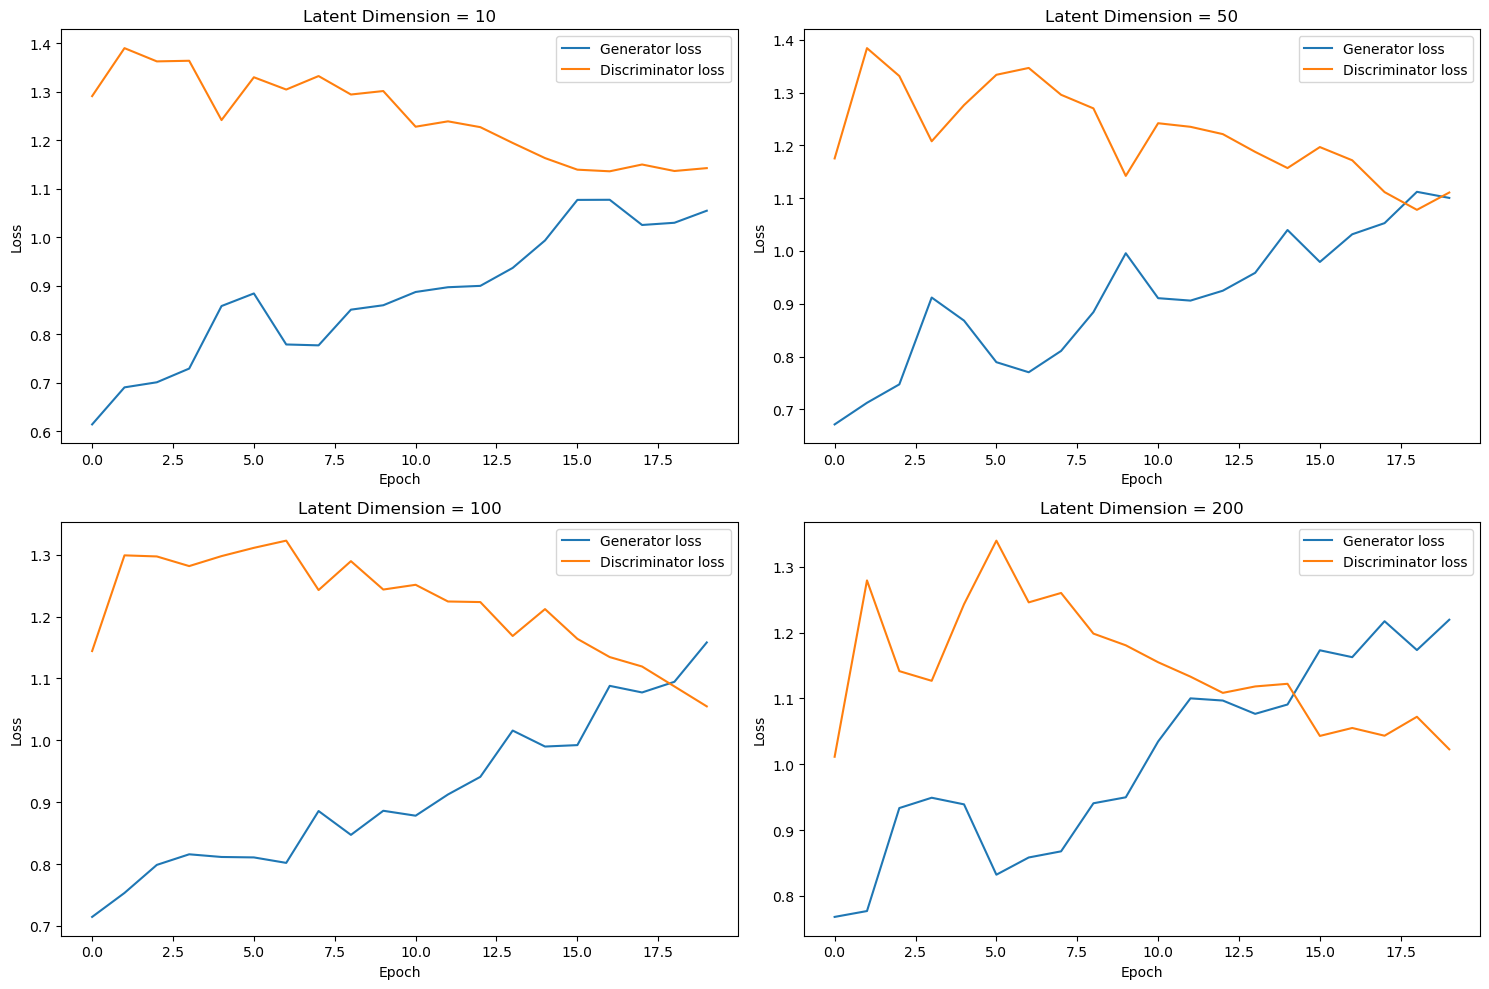

ValueError: num must be an integer with 1 <= num <= 16, not 17

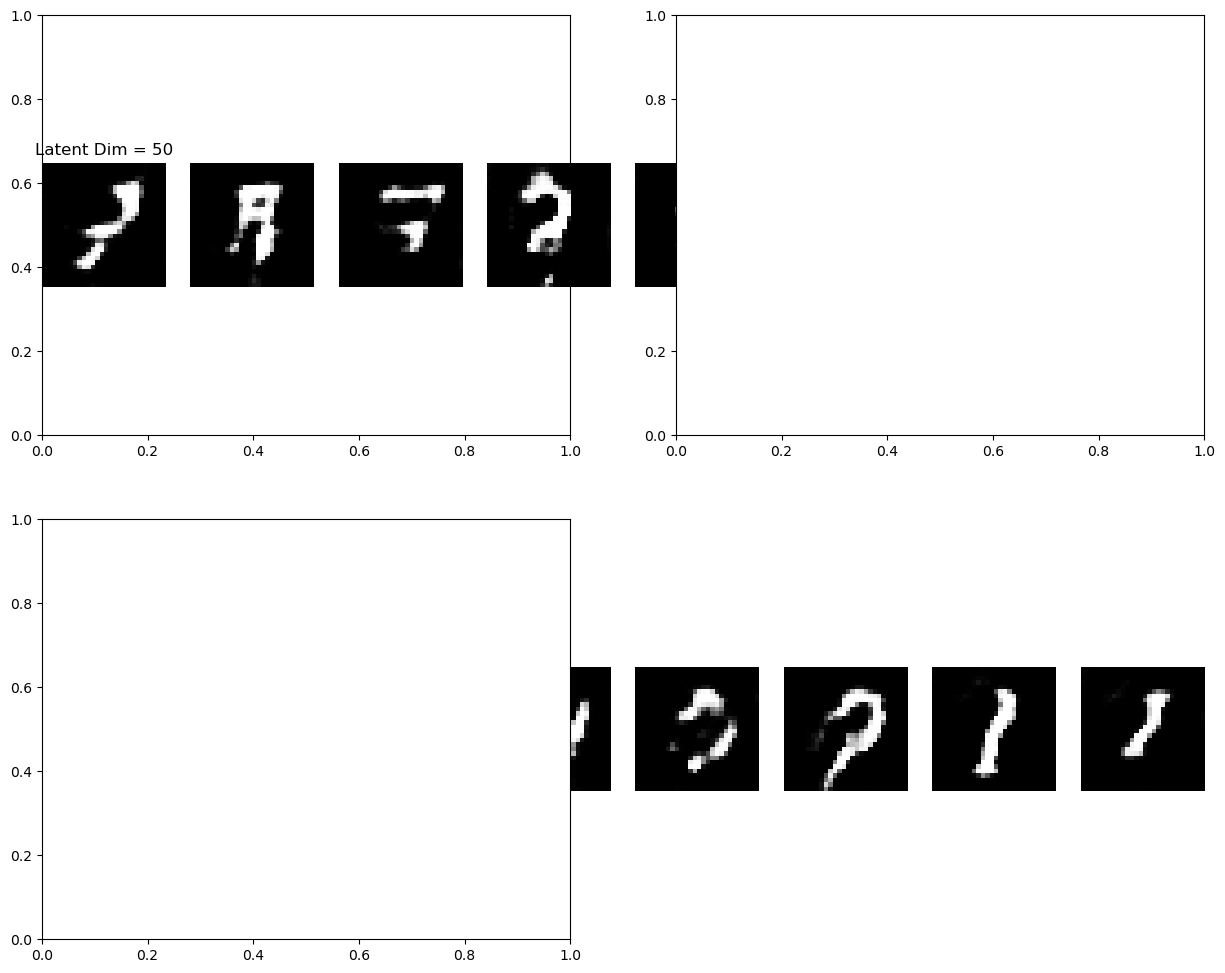

In [82]:
def train_gan_with_latent_dim(dataset, latent_dim, epochs=20):
    # Build models with the specified latent dimension
    generator = build_generator(latent_dim=latent_dim)
    discriminator = build_discriminator()
    
    # Define optimizers
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
    
    # Create seed for consistent visualization
    seed = tf.random.normal([16, latent_dim])
    
    # Training loop
    gen_losses = []
    disc_losses = []
    
    for epoch in range(epochs):
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        steps = 0
        
        for image_batch in dataset:
            noise = tf.random.normal([BATCH_SIZE, latent_dim])
            
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generate fake images
                generated_images = generator(noise, training=True)
                
                # Get discriminator outputs
                real_output = discriminator(image_batch, training=True)
                fake_output = discriminator(generated_images, training=True)
                
                # Calculate losses
                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)
                
            # Calculate gradients
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            
            # Apply gradients
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            steps += 1
        
        epoch_gen_loss /= steps
        epoch_disc_loss /= steps
        gen_losses.append(epoch_gen_loss.numpy())
        disc_losses.append(epoch_disc_loss.numpy())
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Gen Loss: {epoch_gen_loss:.4f}, Disc Loss: {epoch_disc_loss:.4f}')
    
    # Generate final images
    final_images = generator(seed, training=False)
    
    return generator, discriminator, gen_losses, disc_losses, final_images

# Test different latent dimensions
latent_dims = [10, 50, 100, 200]
mnist_results = {}

for dim in latent_dims:
    print(f"Training MNIST GAN with latent dimension {dim}")
    generator, discriminator, gen_losses, disc_losses, final_images = train_gan_with_latent_dim(
        mnist_dataset, dim, epochs=20)
    mnist_results[dim] = {
        'generator': generator,
        'discriminator': discriminator,
        'gen_losses': gen_losses,
        'disc_losses': disc_losses,
        'final_images': final_images
    }

# Visualize the results
plt.figure(figsize=(15, 10))

for i, dim in enumerate(latent_dims):
    plt.subplot(2, 2, i+1)
    plt.plot(mnist_results[dim]['gen_losses'], label='Generator loss')
    plt.plot(mnist_results[dim]['disc_losses'], label='Discriminator loss')
    plt.title(f'Latent Dimension = {dim}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.savefig('latent_dim_losses.png')
plt.show()

# Compare final generated images
plt.figure(figsize=(15, 12))

for i, dim in enumerate(latent_dims):
    plt.subplot(2, 2, i+1)
    images = mnist_results[dim]['final_images']
    
    for j in range(16):
        plt.subplot(2, 8, j+1 + (i//2)*16)
        plt.imshow(images[j, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.title(f'Latent Dim = {dim}')

plt.tight_layout()
plt.savefig('latent_dim_images.png')
plt.show()

## Conclusion

In this notebook, we've explored the application of GANs for image generation on two datasets of differing complexity: MNIST and Fashion-MNIST. Here are our key findings:

1. **Dataset Complexity Matters**: 
   - GANs perform better on simpler datasets like MNIST compared to the more complex Fashion-MNIST
   - The training process is generally more stable for MNIST

2. **Model Architecture Considerations**:
   - The same DCGAN architecture can produce varying results depending on the dataset
   - BatchNormalization and LeakyReLU activations help stabilize training
   - The discriminator is prone to overpowering the generator without careful tuning

3. **Data Augmentation Potential**:
   - GAN-generated images can be effective for data augmentation, particularly when training data is limited
   - The benefits of augmentation depend on the quality of the generated images

4. **Hyperparameter Sensitivity**:
   - The latent dimension size affects the model's capability to capture the data distribution
   - Too small: limited expressivity; Too large: potential overfitting or difficulties in training

5. **Evaluation Metrics**:
   - Visual inspection remains important but can be subjective
   - Distribution matching metrics help quantify how well the GAN captures the true data distribution

### Future Directions

To improve GANs for image generation, we could explore:

1. **Advanced Architectures**:
   - Wasserstein GANs for improved stability
   - Progressive GANs for higher resolution images
   - StyleGANs for better control over image features

2. **Conditional Generation**:
   - Conditional GANs (CGANs) to generate images of specific classes
   - Text-to-image GANs for generating images from descriptions

3. **Evaluation Metrics**:
   - Inception Score (IS) and Fréchet Inception Distance (FID) for more robust quality assessment
   - Precision and Recall metrics to measure both quality and diversity

GANs have proven to be powerful tools for data augmentation, but their effectiveness depends on careful implementation and understanding of the dataset's properties. As demonstrated, even a simple DCGAN architecture can produce impressive results on appropriate datasets.

## References

1. Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). Generative Adversarial Nets. In Advances in Neural Information Processing Systems.

2. Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. arXiv preprint arXiv:1511.06434.

3. Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. arXiv preprint arXiv:1708.07747.

4. LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.

5. Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., & Chen, X. (2016). Improved Techniques for Training GANs. In Advances in Neural Information Processing Systems.

6. Arjovsky, M., Chintala, S., & Bottou, L. (2017). Wasserstein Generative Adversarial Networks. In International Conference on Machine Learning.

7. Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium. In Advances in Neural Information Processing Systems.